In [1]:
import os

# change to the root folder
os.chdir("..")

from tests.test_zestimation import *

In [2]:
# plotting styles
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline

mpl.rcParams['figure.dpi']= 150

# Quasar Redshift Estimations

In this notebook, we will use the Gaussian process model proposed in [Leah (2020)](https://arxiv.org/abs/2006.07343).

The idea is to build a GP in rest-frame wavelengths ($\lambda$) from 911~3000 Angstrom. This is because we expect emission spectra should be the same for different quasars.

![Mean function](https://user-images.githubusercontent.com/23435784/134263464-641882f5-49ce-4204-8ca8-fefb799bfdd1.png)

The above figure is from Leah (2020). We labelled different emission lines (Ly$\alpha$, Ly$\beta$, CIV, etc.) in the plot. It is the mean function of the trained GP model. The mean function is simply the mean vector take from the training set. We chose to normalize the spectra between 1176~1256 Angstrom. That's why the value of the mean function is close to unity at 1216.

To specify a Gaussian process, besides the mean function, we need to have the covariance kernel. We trained the covariance kernel from the training set. Detailed calculations could be found at Leah (2020).

![Correlation kernel](https://user-images.githubusercontent.com/23435784/134263474-9db68b60-c93b-4900-adce-93b04c505f4e.png)

The above plot is the covariance kernel with the diagonal elements normalized to 1. The range of the values is from -1 to 1. Each element at the matrix (or plot) shows the correlation of quasar emission with another. You can see the patterns of emission lines in the plot. Those patterns are the weapons we use to make a probabilistic statement about the quasars.


In [3]:
# read the first spectrum from SDSS DR12
nspec = 0

# filenames is an array for a list of spectra, and we take one of them here
filename = filenames[nspec]

filename

'spec-6173-56238-0528.fits'

In [4]:
# If we haven't downloaded the file, this cell will help you download the file from SDSS database
if not os.path.exists(filename):
    plate, mjd, fiber_id = re.findall(
        r"spec-([0-9]+)-([0-9]+)-([0-9]+).fits", filename,
    )[0]
    retrieve_raw_spec(int(plate), int(mjd), int(fiber_id))

In [5]:
# make sure the file exists
assert os.path.exists(filename) == True

## Visualize the quasar spectrum

A spectrum describes the number of photons (or the amount of light) we received from the astronomical object (in this case, quasar) at each wavelengths.

In [6]:
# read the raw spectrum
wavelengths, flux, noise_variance, pixel_mask = read_spec(filename)

Text(0, 0.5, 'Flux')

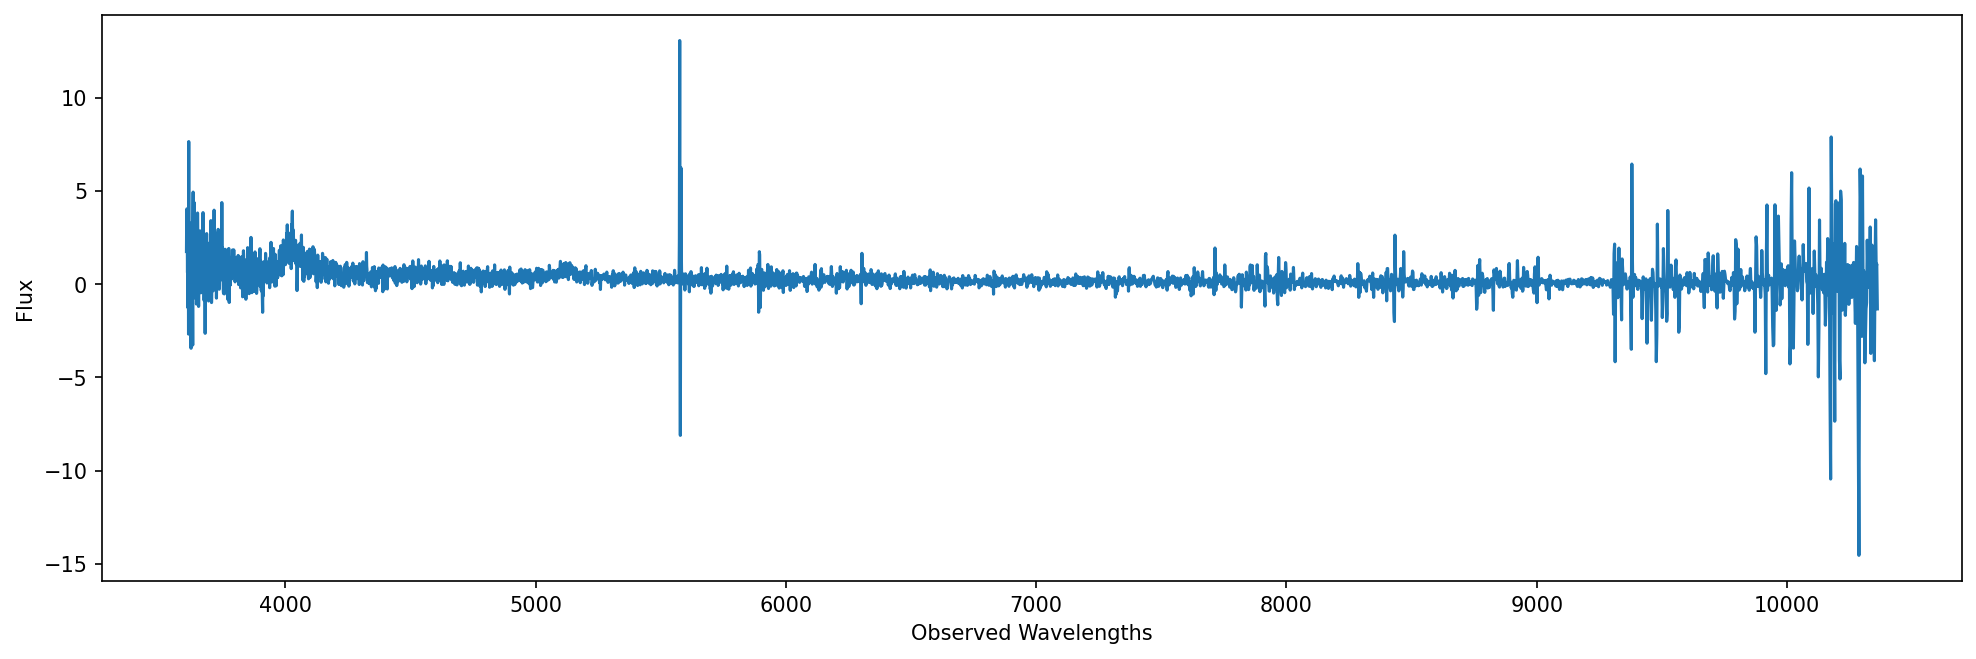

In [7]:
# plot it in "observed wavelengths"
plt.figure(figsize=(16, 5))
plt.plot(wavelengths, flux)
plt.xlabel("Observed Wavelengths")
plt.ylabel("Flux")

Note that the **observed wavelengths** are redshifted, meaning they are stretched by the expansion of the Universe. The conversion of the observed wavelengths to the original wavelengths before redshifts is:

$$
\lambda_\mathrm{obs} = \lambda_\mathrm{rest} \times \frac{1}{a}
$$

$a$ is a number describes the size of the Universe, with a values $0 < a \leq 1$. At the current time, we have $a = 1$, so the observed wavelengths are the same as the original wavelegnths. We annotated the original wavelengths are $\lambda_\mathrm{rest}$, meaning the **rest wavelengths** or the wavelengths in the rest-frame.

$a$ is equal to $1/(1 + z)$, where $z$ is the redshift.

$$
\lambda_\mathrm{obs} = \lambda_\mathrm{rest} \times (1 + z)
$$



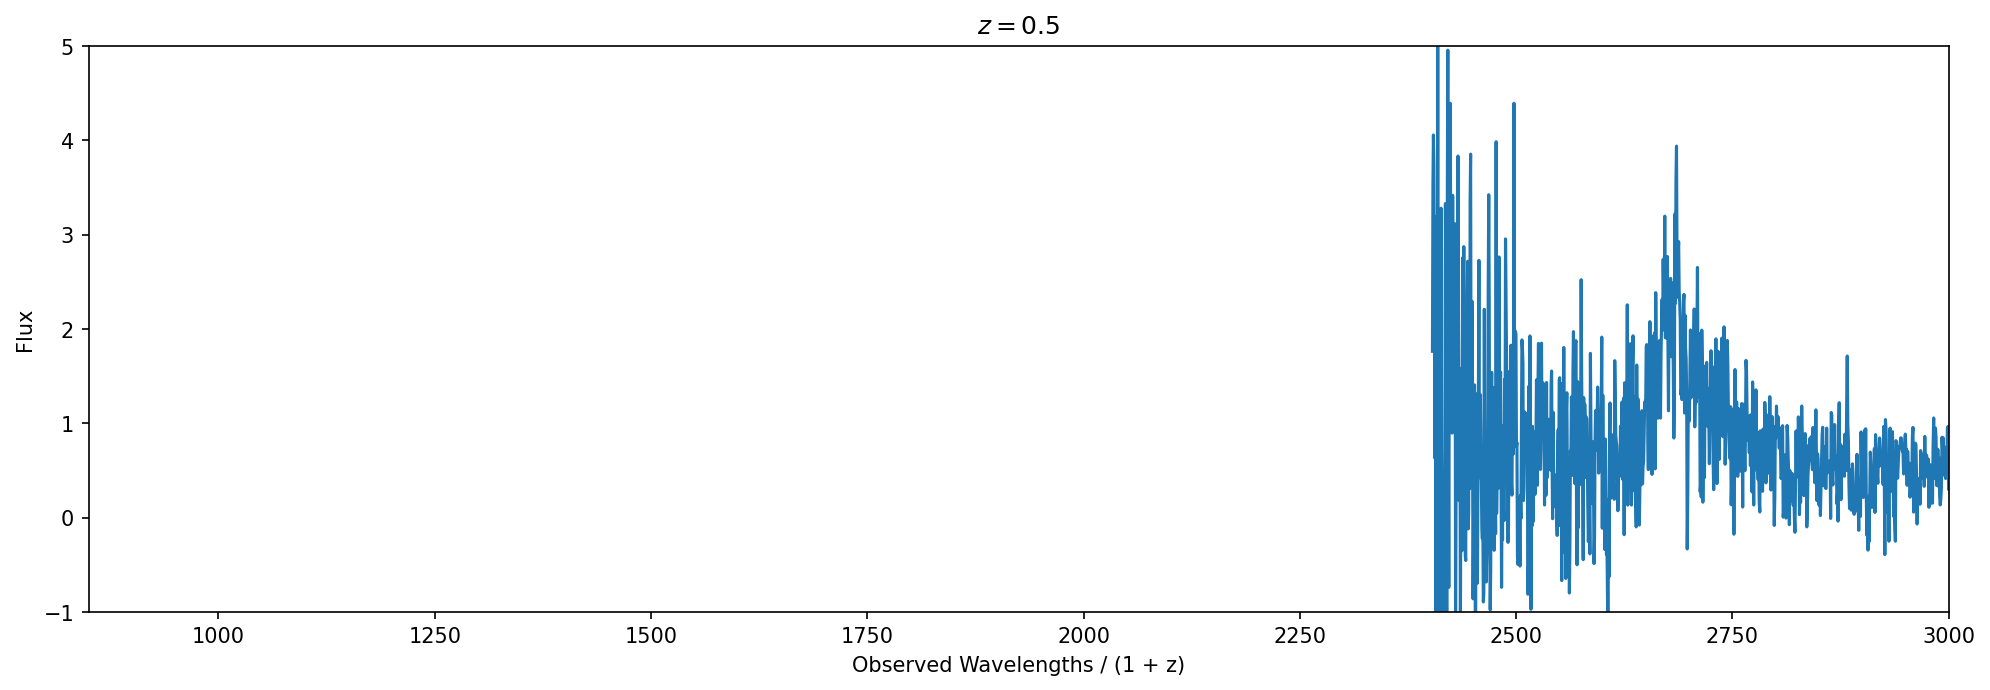

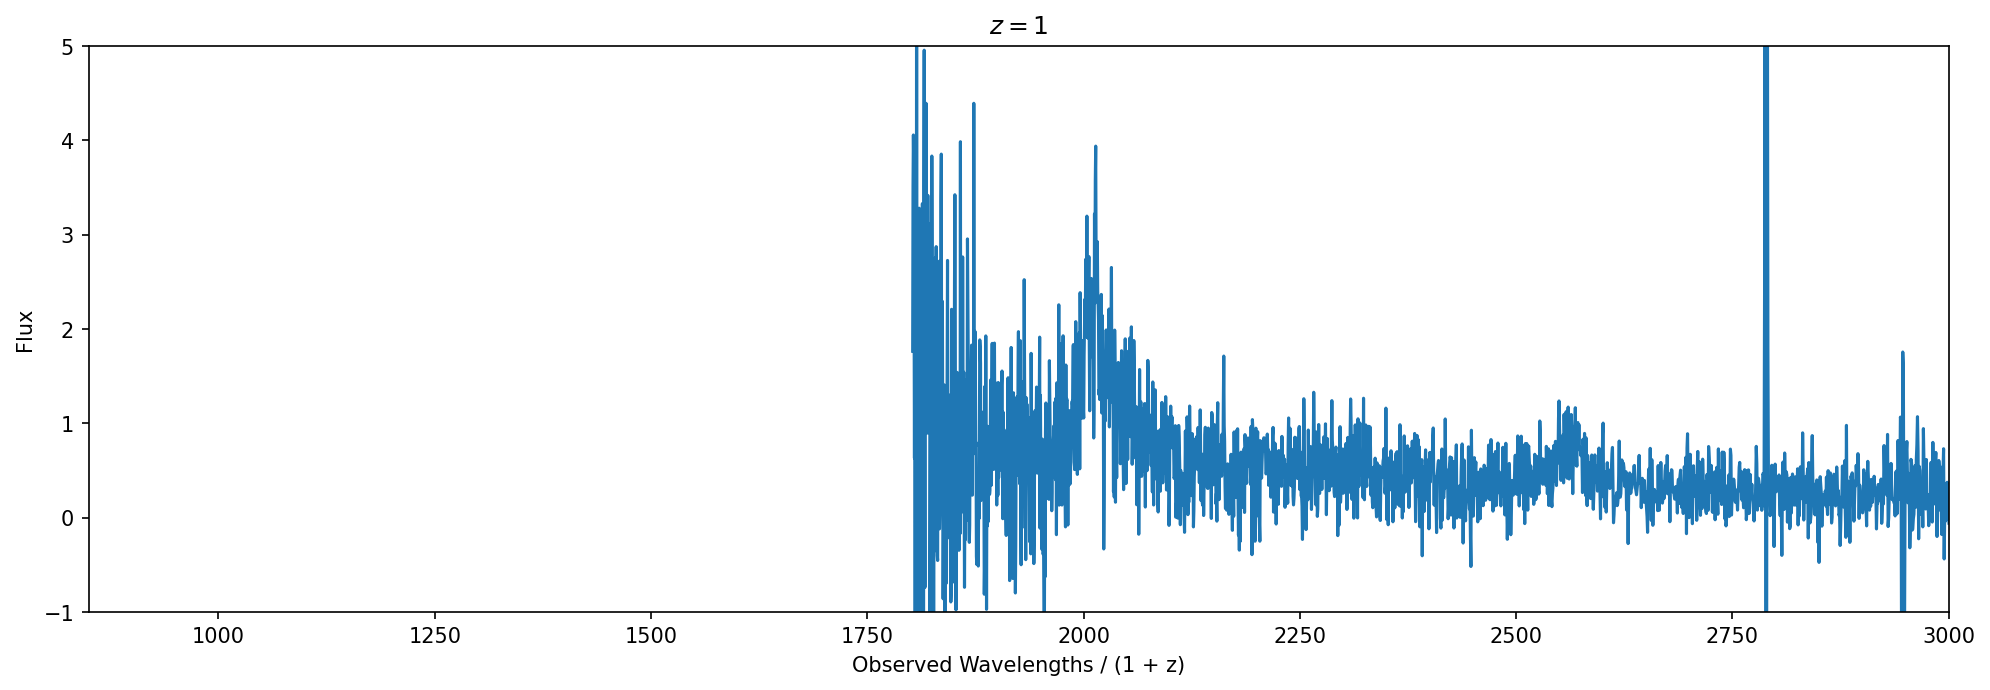

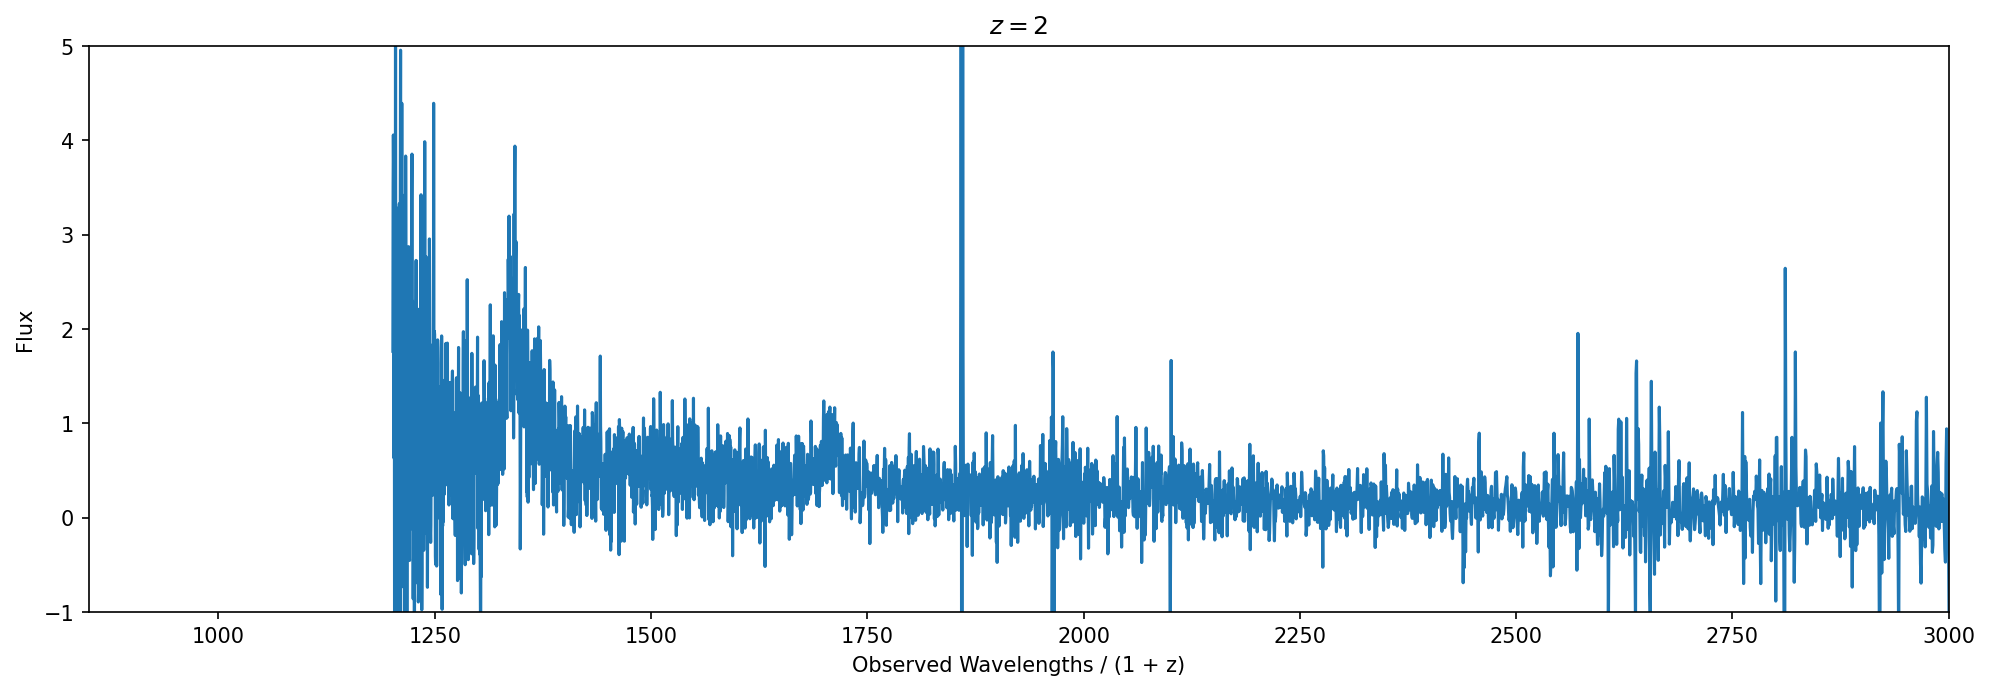

In [8]:
# We can try different values of z to see which one makes sense
for z in (0.5, 1, 2):
    rest_wavelengths = wavelengths / (1 + z)
    plt.figure(figsize=(16, 5))
    plt.title("$z = {}$".format(z))
    plt.plot(rest_wavelengths, flux)
    plt.ylim(-1, 5)
    plt.xlim(850, 3000)
    plt.xlabel("Observed Wavelengths / (1 + z)")
    plt.ylabel("Flux")    

## How to measure the redshift of an astronomical object?

A higher value of $z$:
1. The astronomical object is more distant.
2. The astronomical object is moving away from us faster.
3. The astronomical object emitted the light in an earlier Universe.

Astronomers usually use redshift, $z$, as a distance measure.

So the problem is how do we know the value of $z$?

We know there are several emission lines are usually in quasar spectrum. For example, 

| Rest-Wavelength | Emission Line |
| --- | --- |
| 1215.24 | $Ly\alpha$ (Lyman Alpha) |
| 1549.48 | CIV (Carbon Four)  |
| 2799.117 | MgII (Magnesium Two) |

See the detailed table in [here](https://classic.sdss.org/dr6/algorithms/linestable.html).

Therefore, a naive way is to just try a bunch a different redshifts, until the spectrum with "Observed Wavelengths / (1 + z)" fits the rest-wavelengths of those lab-recorded emission lines.

In [9]:
# Names and Rest-Wavelengths of the Emission Lines
emission_rest_wavelengths = [1215.24, 1549.48, 2799.117]
emission_names = [r"Ly$\alpha$", r"CIV", r"MgII"]

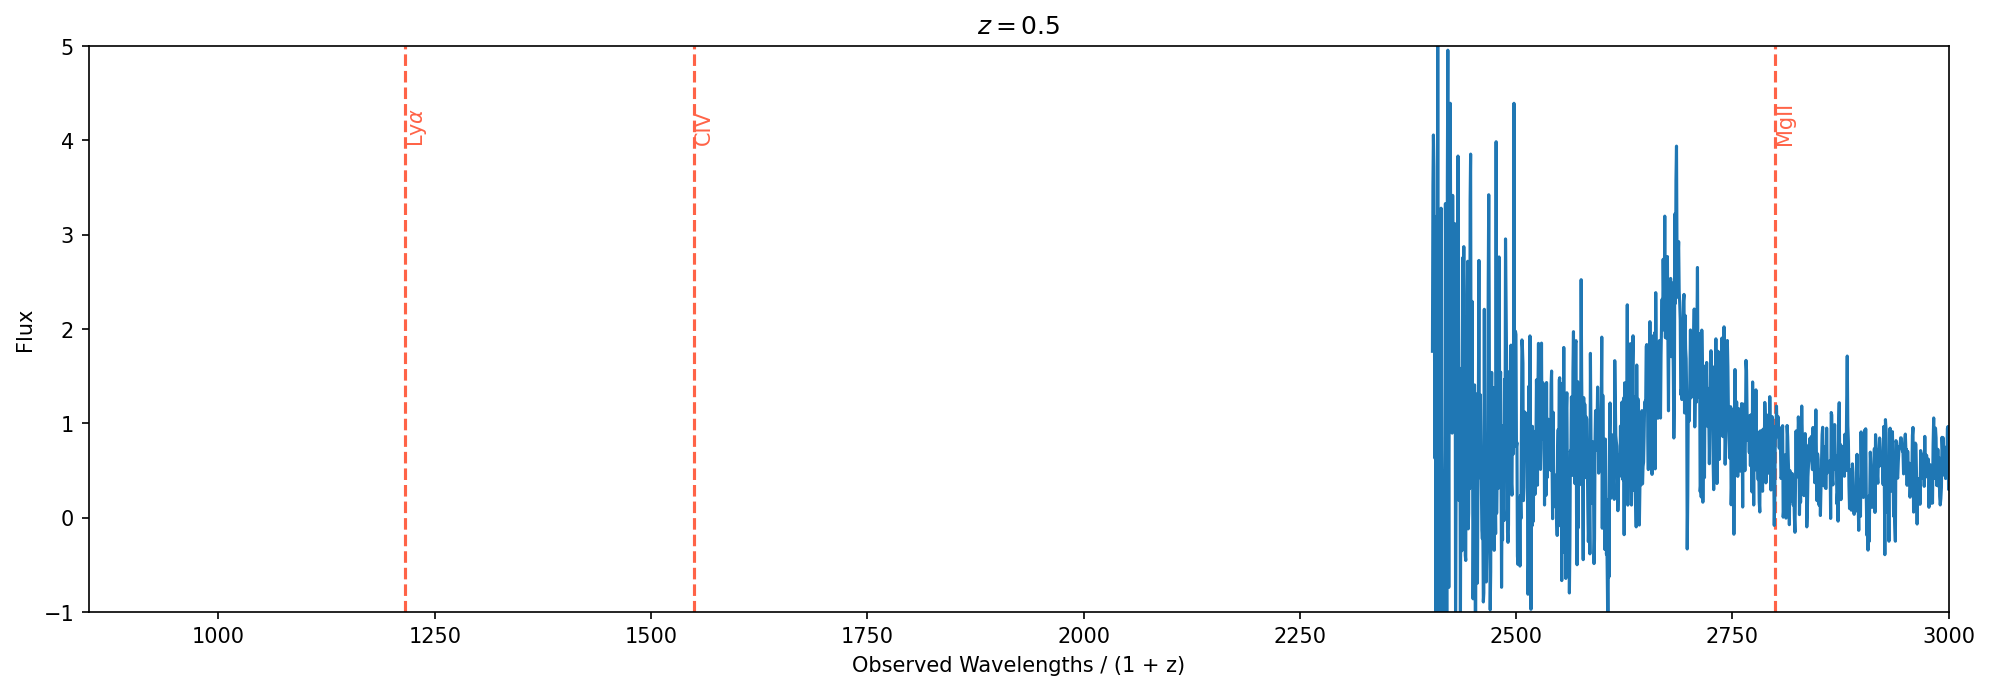

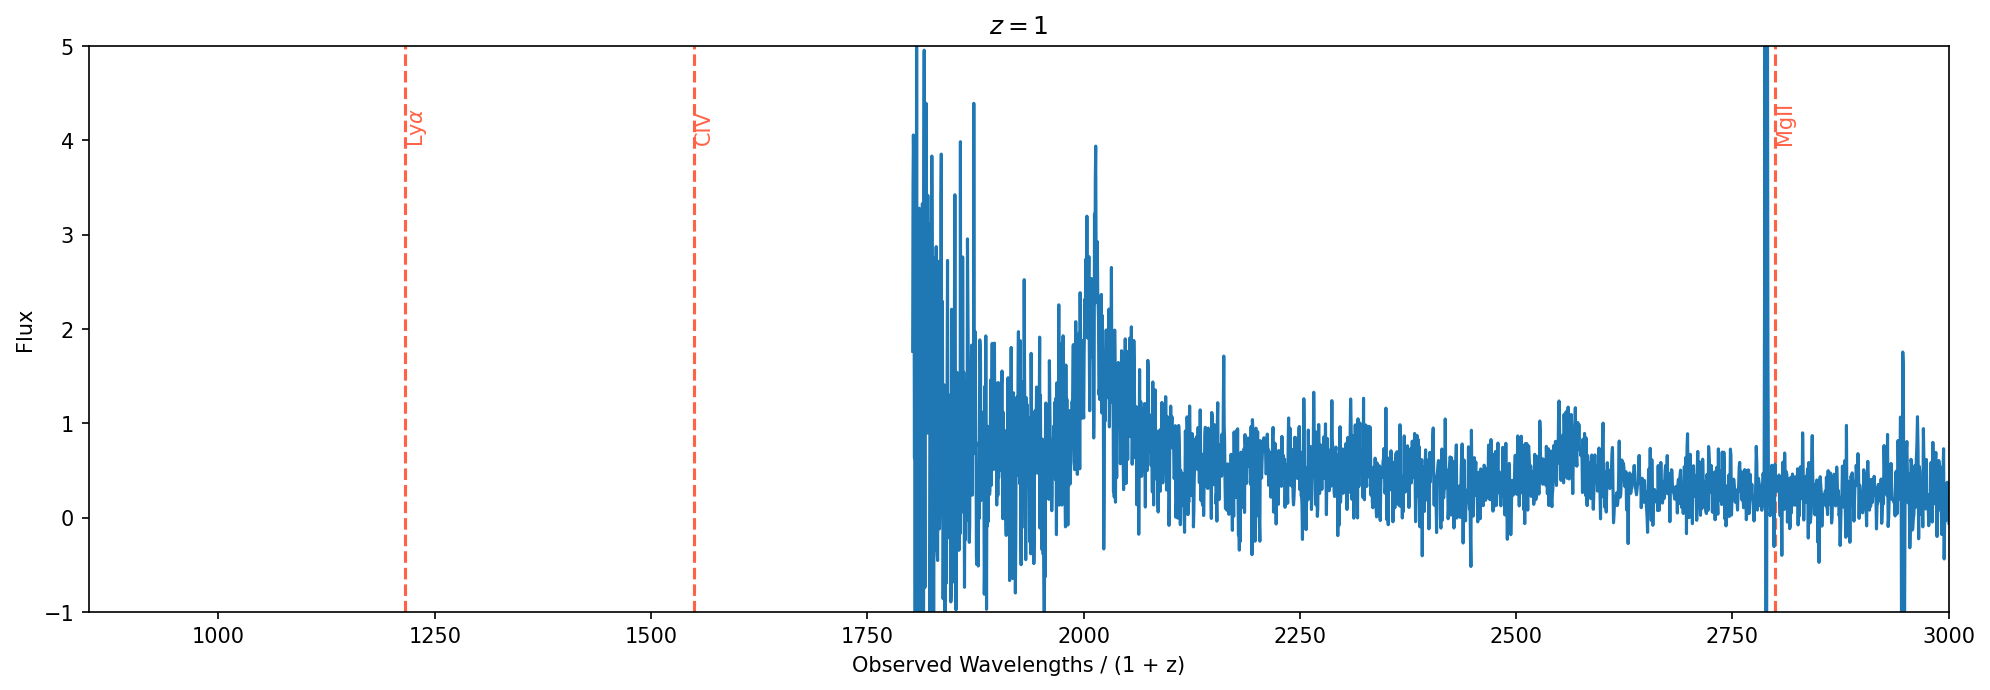

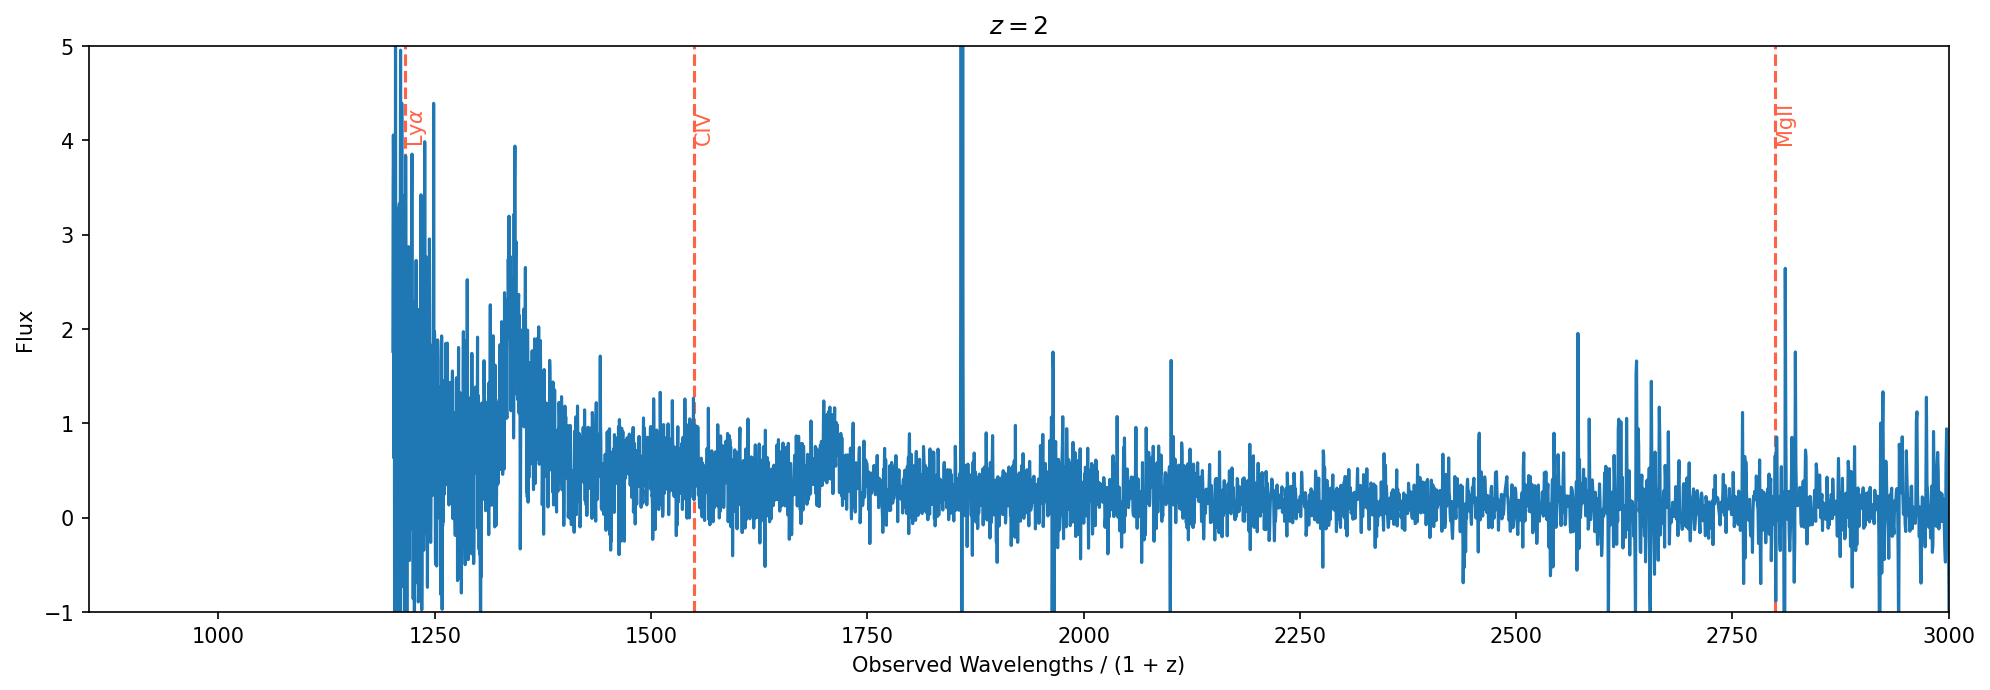

In [10]:
# Let's try several wavelegths and also plot the emission lines
# We can try different values of z to see which one makes sense
for z in (0.5, 1, 2):
    rest_wavelengths = wavelengths / (1 + z)
    plt.figure(figsize=(16, 5))
    plt.title("$z = {}$".format(z))
    plt.plot(rest_wavelengths, flux)
    plt.ylim(-1, 5)
    plt.xlim(850, 3000)
    plt.xlabel("Observed Wavelengths / (1 + z)")
    plt.ylabel("Flux")

    # plot the emission lines to help measure the z
    for n, w in zip(emission_names, emission_rest_wavelengths):
        plt.vlines(w, -1, 5, color="tomato", ls="--")
        plt.text(w, 4, n, rotation="vertical", color="tomato")


Apparently, none of them fit very well. But you kind of guess $z = 2$ should be a very close value because the Lyman alpha at 1216 is next to a bump, and CIV at 1549 is next to another bump. So you might guess it is something slightly larger than $z = 2$.

Let's try $z = 2.3$.

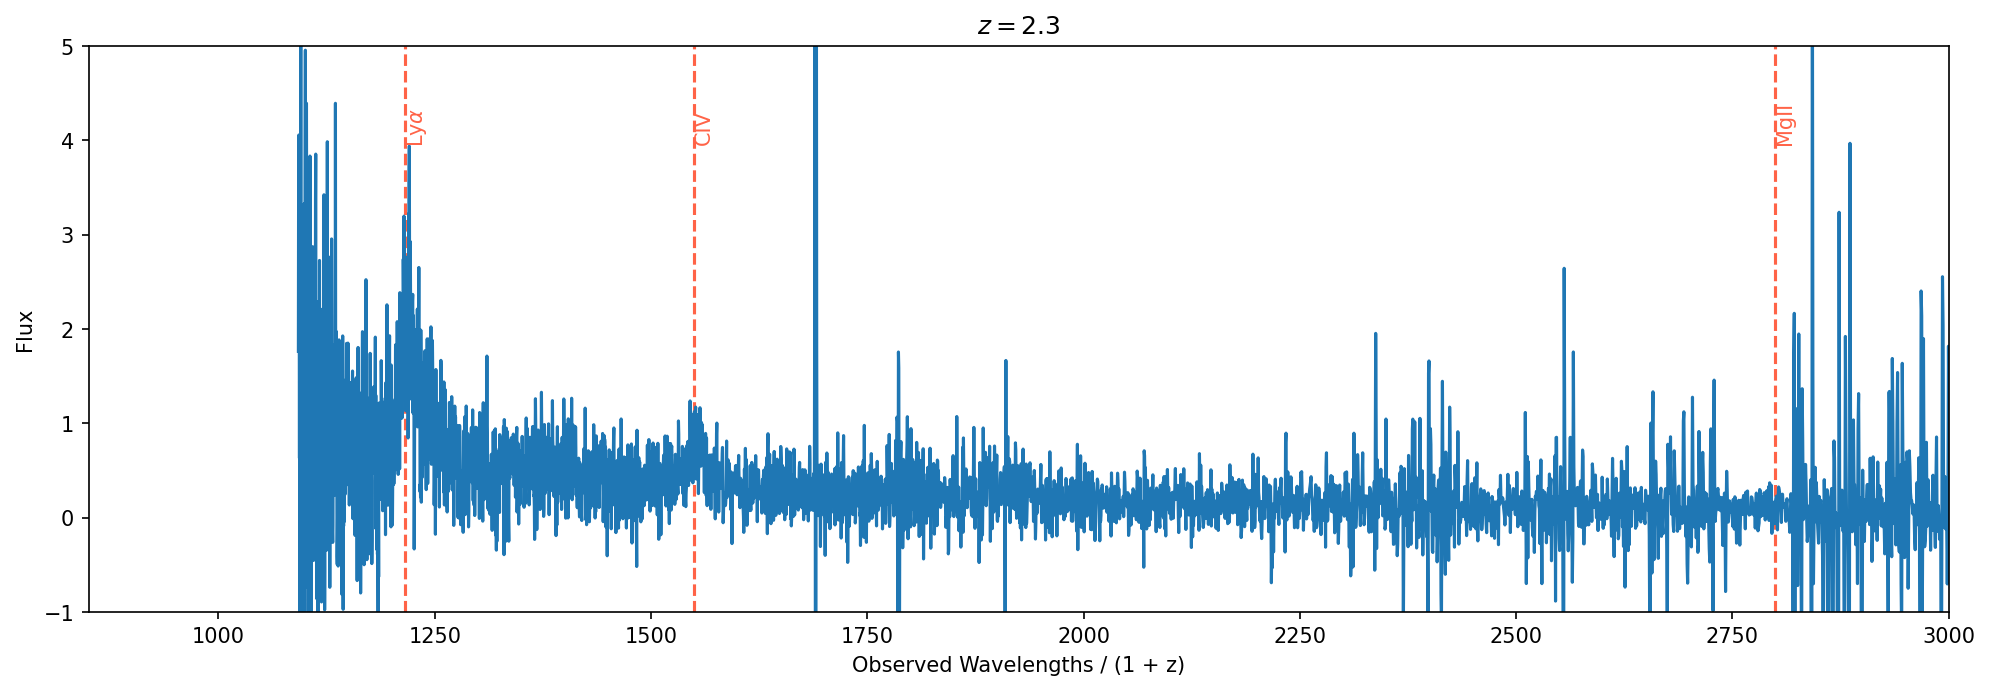

In [11]:
# a geuess, z = 2.3, to see if it fits
z = 2.3

rest_wavelengths = wavelengths / (1 + z)
plt.figure(figsize=(16, 5))
plt.title("$z = {}$".format(z))
plt.plot(rest_wavelengths, flux)
plt.ylim(-1, 5)
plt.xlim(850, 3000)
plt.xlabel("Observed Wavelengths / (1 + z)")
plt.ylabel("Flux")

# plot the emission lines to help measure the z
for n, w in zip(emission_names, emission_rest_wavelengths):
    plt.vlines(w, -1, 5, color="tomato", ls="--")
    plt.text(w, 4, n, rotation="vertical", color="tomato")


It looks like it fits pretty well! And the true value from the SDSS database is $z = 2.309$, so it makes sense it fit quite well with $z = 2.3$.

In [12]:
# database value
z_qsos[nspec]

2.30909729

## How to automate this?

Now, the question is, how do we automate this process without using our eyes? You would probably imagine a machine that when the red dashed lines overlapping with the emission peaks in the spectrum, then the machine will send you a message saying, "hey, I found the redshift!"

That machine will be our Gaussian process model. Instead of directly telling you the redshift, it tells you how likely the redshift you give to the machine is the true one.

In [13]:
# Initialize the model parameters
params = ZParameters()
z_qso_samples = ZSamples(params)

In [14]:
# parameter variable gives you the default parameters we want to use the redshift estimation method
params

{'normalization_min_lambda': 1176.0, 'normalization_max_lambda': 1256.0, 'min_lambda': 910.0, 'max_lambda': 3000.0, 'dlambda': 0.25, 'k': 20, 'max_noise_variance': 16.0, 'num_zqso_samples': 10000, 'minFunc_options': {'MaxIter': 4000, 'MaxFunEvals': 8000}}

To get the GP model, you need to download the file from [here](https://drive.google.com/file/d/1dmqy6mw7U1cInvQof0o9TTh1JtHwf8jw/view?usp=sharing). 

Save the file to `data/dr12q/processed/learned_zqso_only_model_outdata_full_dr9q_minus_concordance_norm_1176-1256.mat` (or your prefered place)

In [15]:
learned_file = "data/dr12q/processed/learned_zqso_only_model_outdata_full_dr9q_minus_concordance_norm_1176-1256.mat"

# load the model
z_qso_gp = ZGPMAT(
    params,
    z_qso_samples,
    learned_file=learned_file,
)

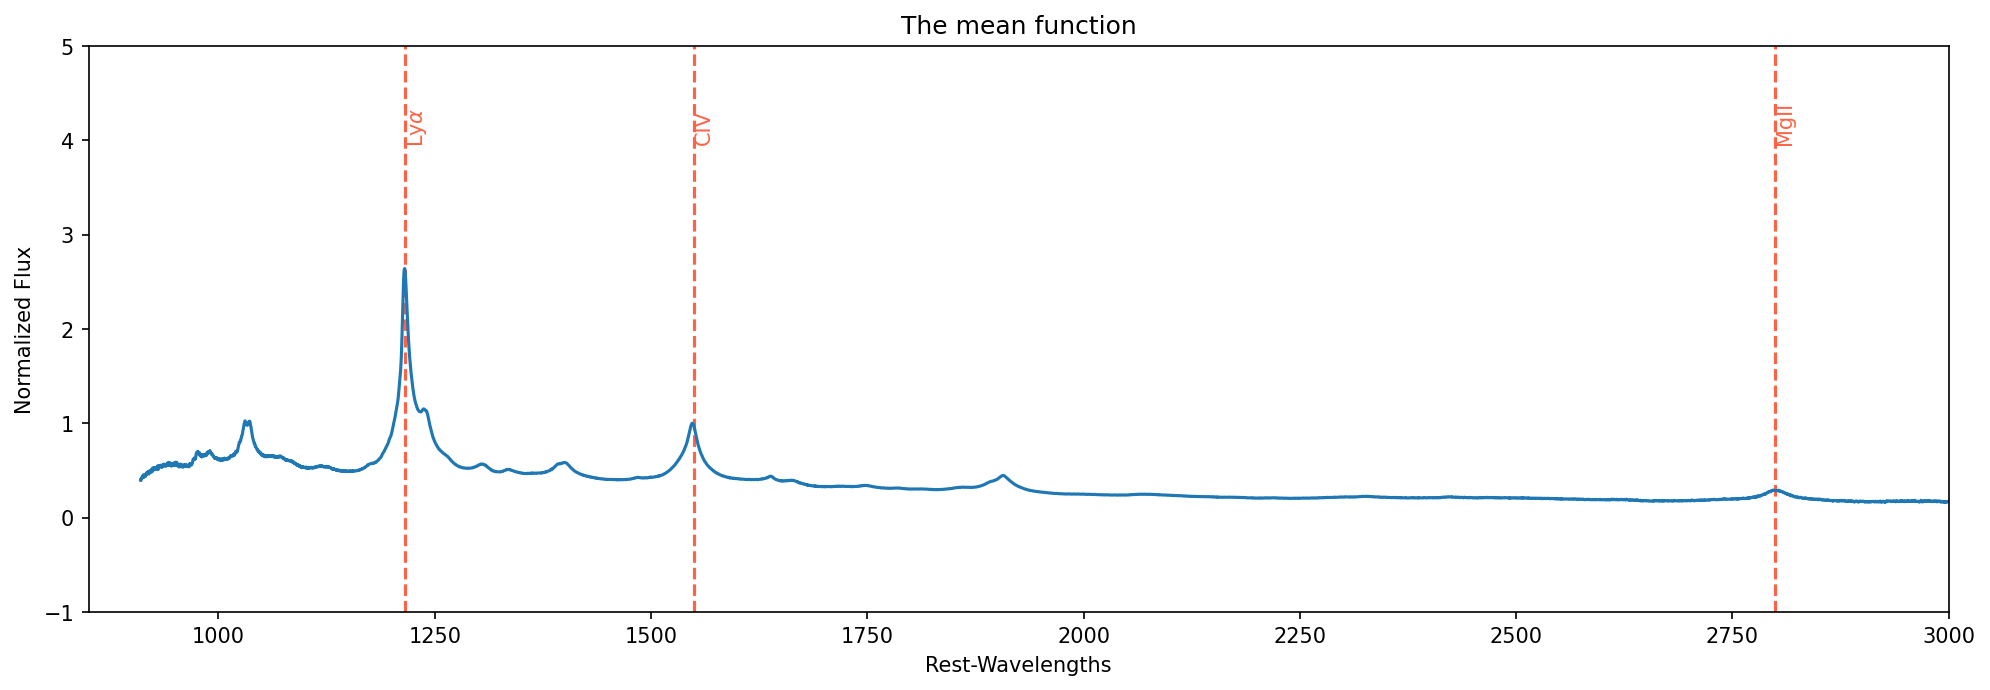

In [16]:
# Plot the model
plt.figure(figsize=(16, 5))
plt.title("The mean function")
plt.plot(z_qso_gp.rest_wavelengths, z_qso_gp.mu)
plt.ylim(-1, 5)
plt.xlim(850, 3000)
plt.xlabel("Rest-Wavelengths")
plt.ylabel("Normalized Flux")

# plot the emission lines to help measure the z
for n, w in zip(emission_names, emission_rest_wavelengths):
    plt.vlines(w, -1, 5, color="tomato", ls="--")
    plt.text(w, 4, n, rotation="vertical", color="tomato")

The idea is just to use the GP model and discard the red dashed lines. So, from now on, the GP mode will be the indicator telling us how well our model can fit the data.

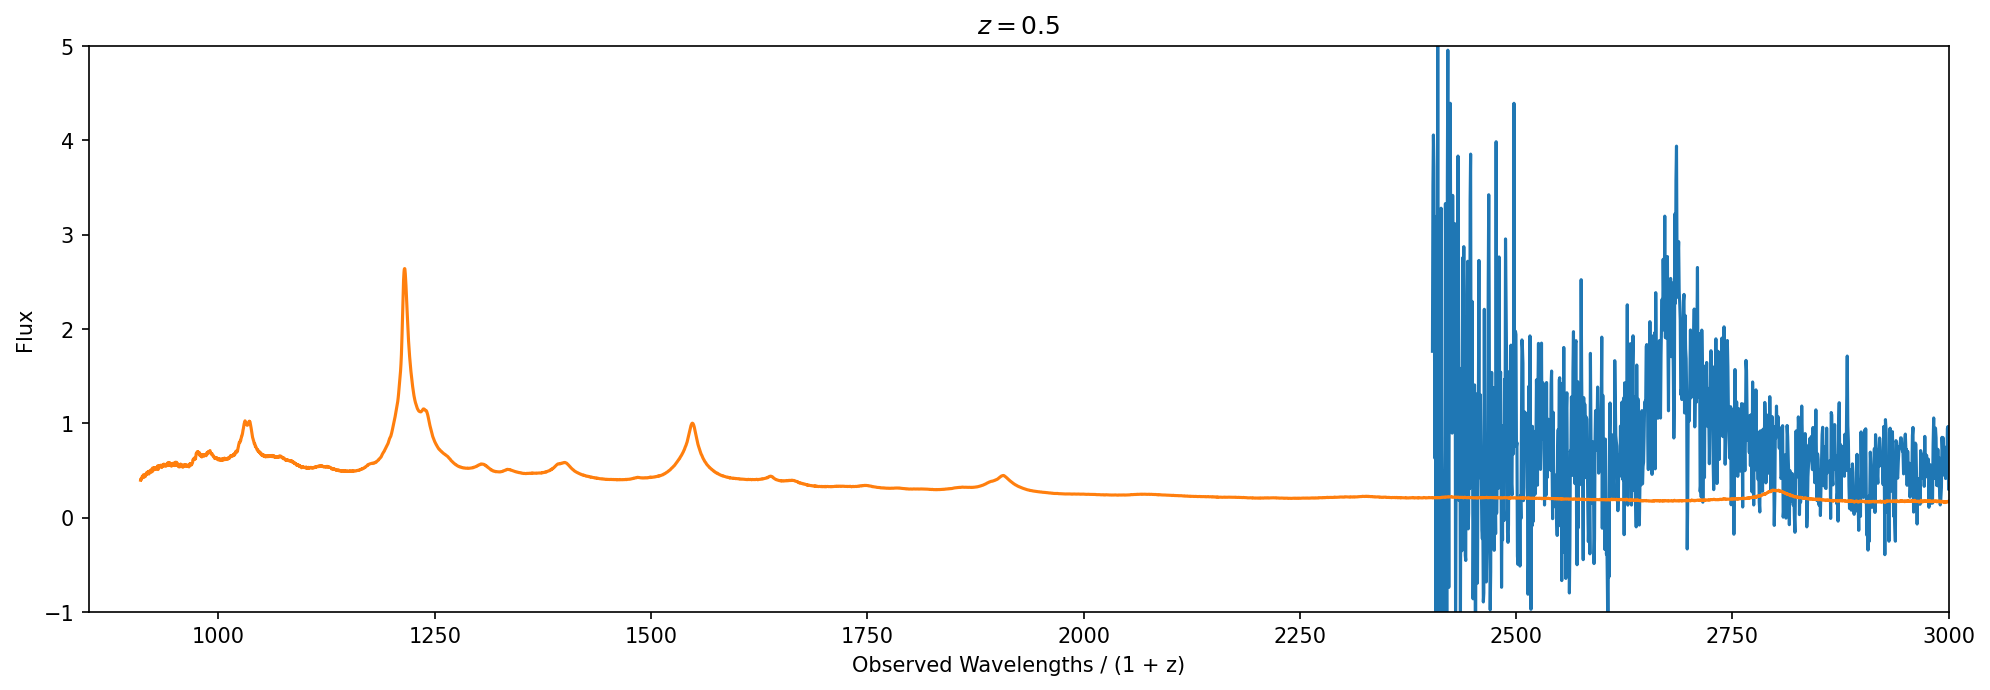

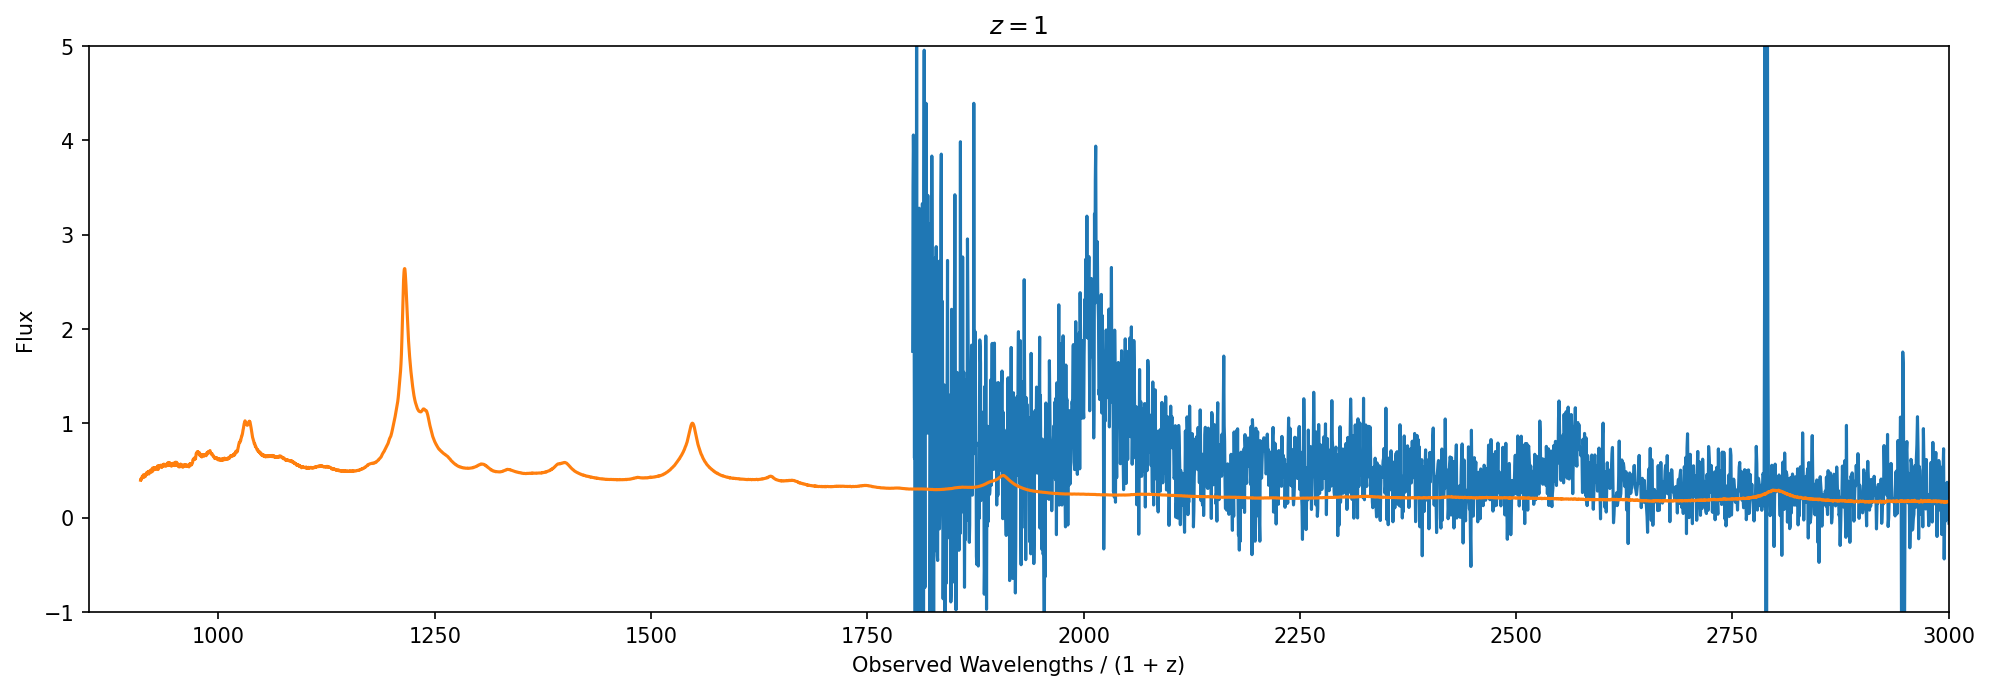

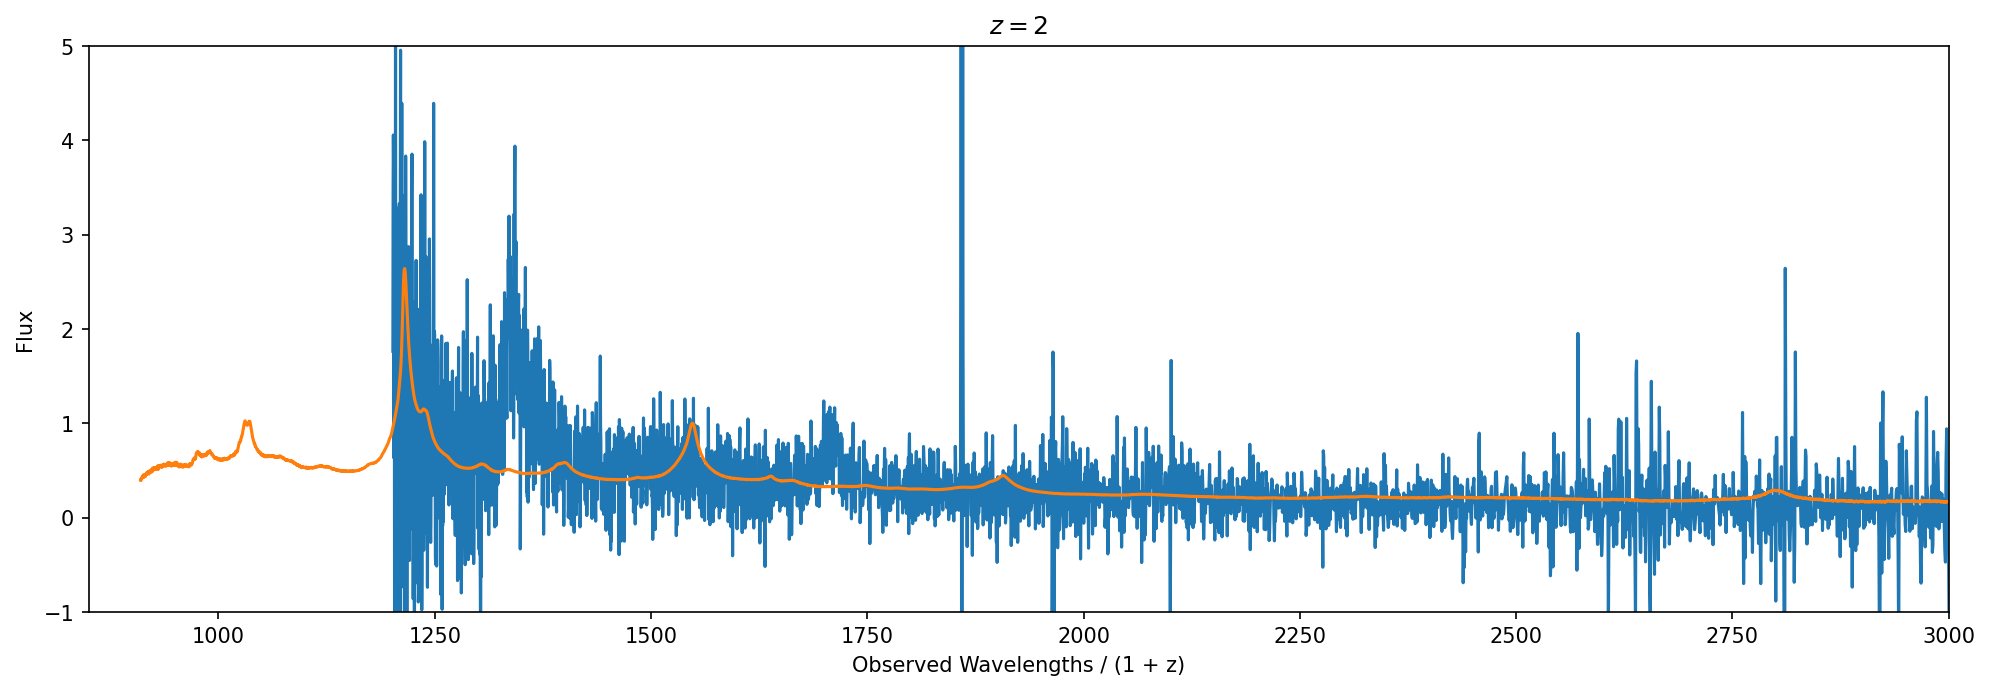

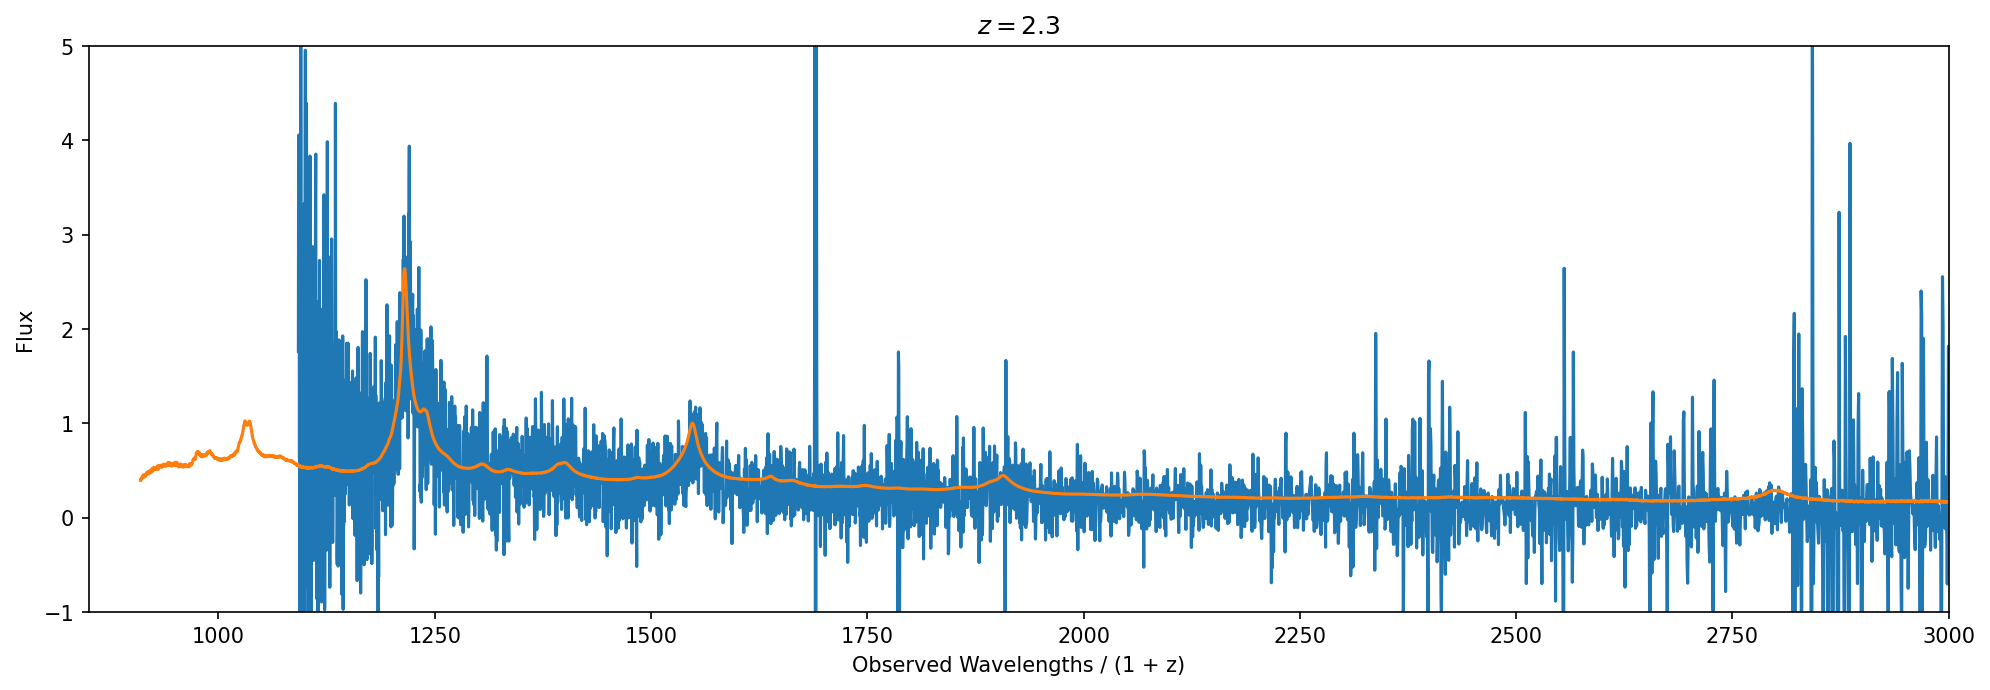

In [17]:
# Overlapping the GP model with the spectrum
# Let's try several wavelegths and also plot the emission lines
# We can try different values of z to see which one makes sense
for z in (0.5, 1, 2, 2.3):
    rest_wavelengths = wavelengths / (1 + z)
    plt.figure(figsize=(16, 5))
    plt.title("$z = {}$".format(z))
    plt.plot(rest_wavelengths, flux)
    plt.ylim(-1, 5)
    plt.xlim(850, 3000)
    plt.xlabel("Observed Wavelengths / (1 + z)")
    plt.ylabel("Flux")

    # plot the GP model to help measure the z
    plt.plot(z_qso_gp.rest_wavelengths, z_qso_gp.mu, label="GP", color="C1")

You can see that, by examining how well the GP mean function fits to the specturm, you can also tell which redshift is more likely to be the correct one by eyes.

### Just run a bunch of test redshifts

The way to automate this process (fitting by eyes) is to run a bunch of redshift. And choose the one which is most likely to be true. The nice thing about GP is that it gives you a value of likelihood for each redshift value.

In [18]:
# For example, for the redshift values we tried before, we want to have the values of likelihoods
test_redshifts = [0.5, 1, 2, 2.3, 3]

sample_log_likelihoods = []

# loop over all of the test redshift, fit the GP to the data, get the likelihood value
for i, z_qso in enumerate(test_redshifts):
    # [fit the GP to the data] set the data and interpolate the model
    z_qso_gp.set_data(
        wavelengths,
        flux,
        noise_variance,
        pixel_mask,
        z_qso=z_qso,
        normalize=True,
        build_model=True,
    )
    
    # [get the likelihood value]
    sample_log_likelihoods.append(z_qso_gp.log_model_evidence())

/home/jibancat/.pyenv/versions/3.7.10/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/jibancat/Documents/PYTHON/gpy_dla_detection/gpy_dla_detection/zqso_gp.py:177: RuntimeWarning: Mean of empty slice
  self.v[np.isinf(self.v)] = np.nanmean(self.v)  # rare kludge to fix bad data


In [19]:
# For z = 0.5, 1, 2, 2.3, 3
# the likelihoods are
sample_log_likelihoods

[nan, nan, -2293.680876656025, -649.8149308330744, -6068.996066995027]

Why the likelihood values are negative is because we computed the likelihood on log scale. It is usually preferable if you calculate probability using a computer.

A higher value of likelihood, a higher probability that this redshift is the true one. So you can see $z = 2.3$ gives log likelihood = -649, which is the highest value among the test redshifts.

Nice! You see now we don't need to plot the figures, but we are still able to tell which redshift is closer to the true one.

So now, imagine doing this for 10,000 times for 10,000 different test redshifts...

In [20]:
# 10,000 test redshifts, from 2 ~ 5
test_redshifts = np.linspace(2, 5, 10000)

sample_log_likelihoods = []

# loop over all of the test redshift, fit the GP to the data, get the likelihood value
for i, z_qso in enumerate(test_redshifts):
    # [fit the GP to the data] set the data and interpolate the model
    z_qso_gp.set_data(
        wavelengths,
        flux,
        noise_variance,
        pixel_mask,
        z_qso=z_qso,
        normalize=True,
        build_model=True,
    )
    
    # [get the likelihood value]
    sample_log_likelihoods.append(z_qso_gp.log_model_evidence())

Now you have 10,000 likelihoods! But how do we know which one gives the best value?

The easiest way is to just plot all of the likelihoods as a function of redshifts.

Text(0, 0.5, 'log likelihoods')

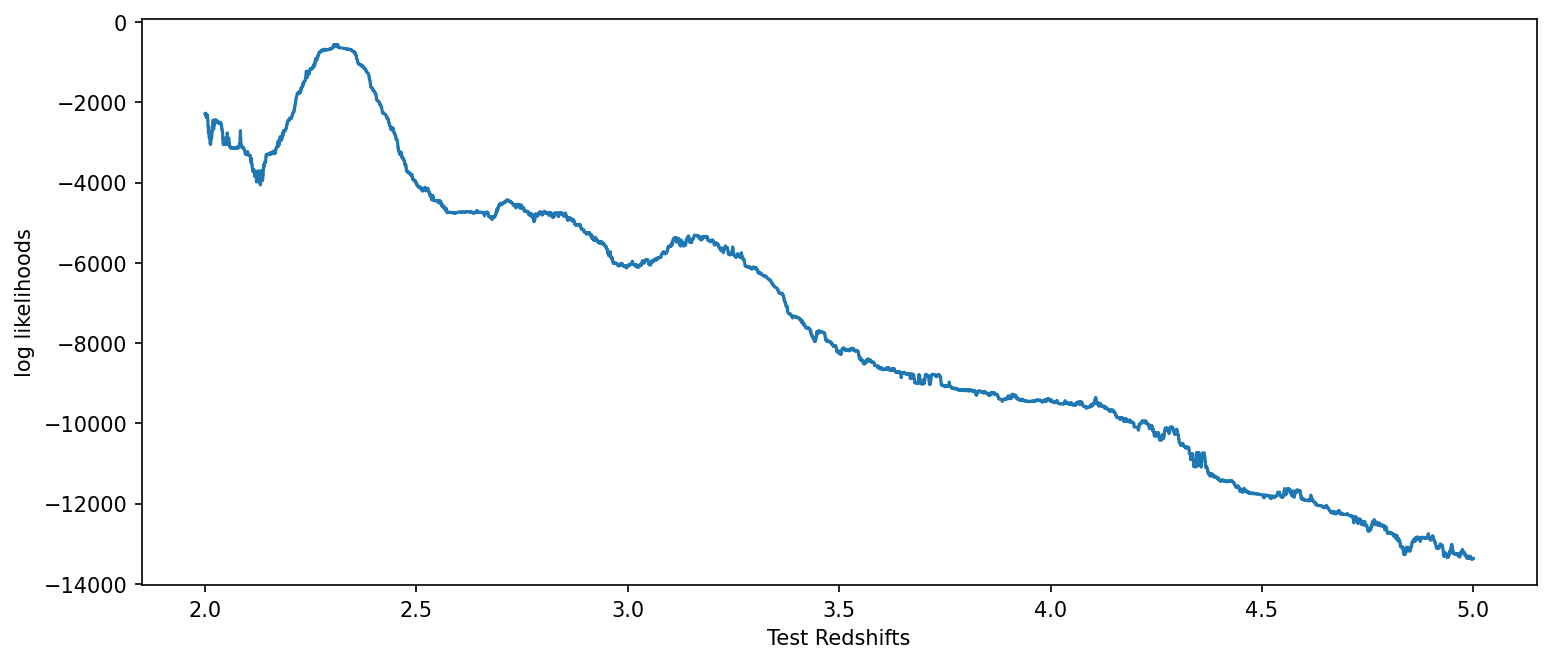

In [21]:
# Plot the likelihoods as a function of redshifts, this helps visaulize the behaviour of the model
plt.figure(figsize=(12, 5))
plt.plot(test_redshifts, sample_log_likelihoods)
plt.xlabel("Test Redshifts")
plt.ylabel("log likelihoods")

The highest likelihood is around 2.25 ~ 2.5. We can do argmax (finding the index for the maximum value) to get the exact value.

In [22]:
# find the redshift gives the highest likelihood
idx = np.argmax(sample_log_likelihoods)
# the predicted redhisft is the redshift gives the highest likelihood
z_pred = test_redshifts[idx]
z_pred

2.3075307530753078

In [23]:
# compare with the value in the catalog
(z_pred - z_qsos[nspec]) / z_qsos[nspec]

-0.0006784196280842801

The relative error is $\sim 0.06 \%$, compared with the value reported in the SDSS database.